# Bank Marketing in python using h2o GBM

Import the required packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import warnings

warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
from teradataml.dataframe.copy_to import copy_to_sql
from teradataml.context.context import get_connection
from teradataml.dataframe.dataframe import DataFrame
from teradataml import create_context
import getpass
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator

Replace your cluster details for your user, password, host and database.

In [3]:
engine = create_context(host="3.238.151.85", username="AOA_DEMO", password=getpass.getpass("password"))

password ··········


## Exploratory analysis

Load and inspect the dataset

In [4]:
dataset = DataFrame("BANK_MARKETING_DATA").to_pandas()
# Visualise a table with the first rows of the dataset, to
# better understand the data format
dataset.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


Check for correlations

In [5]:
corr = dataset.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
corr

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
age,1.000000,0.166402,-0.007715,-0.045936,-0.007067,0.016128,-0.111345,-0.002402,0.050737,0.023363,0.035760,0.026622,-0.010558,0.036239,0.012112,0.045800,0.065228
job,0.166402,1.000000,-0.012186,-0.088132,-0.002168,-0.015648,-0.160040,0.001375,0.024281,0.005493,0.067786,-0.020892,-0.036376,0.024443,0.022966,0.047513,0.068978
marital,-0.007715,-0.012186,1.000000,0.090907,0.049837,-0.026206,-0.027397,-0.014321,-0.031768,0.025010,-0.009086,0.008537,-0.021882,0.009266,-0.001322,-0.000989,0.061242
education,-0.045936,-0.088132,0.090907,1.000000,-0.010534,0.011534,-0.087070,-0.054086,-0.110384,-0.010523,0.072546,-0.012168,0.005049,0.025968,0.027182,0.045689,0.042987
default,-0.007067,-0.002168,0.049837,-0.010534,1.000000,-0.022277,0.006881,0.063994,-0.006654,0.010775,0.013052,-0.039377,-0.012759,-0.028827,-0.028712,-0.031354,0.001303
balance,0.016128,-0.015648,-0.026206,0.011534,-0.022277,1.000000,0.025923,-0.016647,0.018605,-0.007546,-0.012901,0.139572,-0.022156,0.078316,-0.001406,0.006034,0.031489
housing,-0.111345,-0.160040,-0.027397,-0.087070,0.006881,0.025923,1.000000,0.018451,0.097917,-0.048346,-0.300032,0.020312,-0.010403,0.055139,0.046341,0.006302,-0.104683
loan,-0.002402,0.001375,-0.014321,-0.054086,0.063994,-0.016647,0.018451,1.000000,-0.008376,0.049655,0.083930,-0.011070,0.006911,-0.020633,-0.026135,-0.053685,-0.070517
contact,0.050737,0.024281,-0.031768,-0.110384,-0.006654,0.018605,0.097917,-0.008376,1.000000,-0.004404,-0.250411,0.018738,0.032347,-0.132054,-0.123530,-0.149290,-0.082229
day,0.023363,0.005493,0.025010,-0.010523,0.010775,-0.007546,-0.048346,0.049655,-0.004404,1.000000,0.092859,0.003150,0.049538,-0.028044,-0.028344,-0.018421,0.024205


Lets compare the age of the subscribers

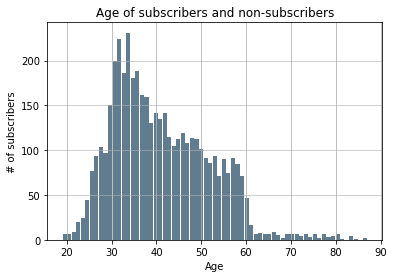

In [6]:
num_bins = dataset['age'].unique().size
dataset['age'].plot.hist(grid=True, bins=num_bins, rwidth=0.9, color='#607c8e')
plt.title('Age of subscribers and non-subscribers')
plt.xlabel('Age')
plt.ylabel('# of subscribers')
plt.grid(axis='y', alpha=0.75)

In the histogram above we can see that there is one customer age that is significantly more prevalent than others.

Now we will visualize subscriber percentage by education level, marital status, occupation, and age:

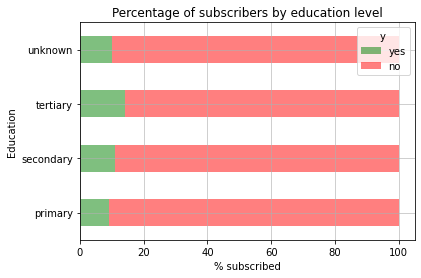

In [7]:
### subscriber % by education level
yn = dataset.groupby(['education', 'y']).size().reset_index(name='counts')
yed = dataset.groupby(['education']).size().reset_index(name='counts')
jed = yn.set_index('education').join(yed.set_index('education'), on='education', how='left', lsuffix='_caller', rsuffix='_other')
jed = jed.assign(perc = (jed['counts_caller']/jed['counts_other']) * 100)
jed = jed.round()
jed = jed.sort_values('y', ascending=True).pivot(columns='y', values='perc')
jed[['yes','no']].plot.barh(stacked=True, color=['Green','Red'], alpha=0.5)
plt.title('Percentage of subscribers by education level')
plt.ylabel('Education')
plt.xlabel('% subscribed')
plt.grid(alpha=0.75)


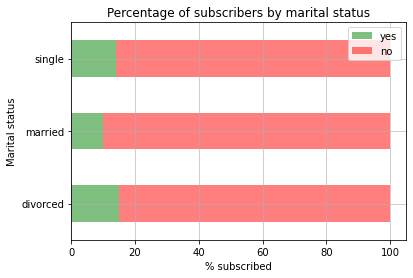

In [8]:
### subscriber % by marital status
yn = dataset.groupby(['marital', 'y']).size().reset_index(name='counts')
yed = dataset.groupby(['marital']).size().reset_index(name='counts')
jed = yn.set_index('marital').join(yed.set_index('marital'), on='marital', how='left', lsuffix='_caller', rsuffix='_other')
jed = jed.assign(perc = (jed['counts_caller']/jed['counts_other']) * 100)
jed = jed.round()
jed = jed.sort_values('y', ascending=True).pivot(columns='y', values='perc')
jed[['yes','no']].plot.barh(stacked=True, color=['Green','Red'], alpha=0.5)
plt.title('Percentage of subscribers by marital status')
plt.ylabel('Marital status')
plt.xlabel('% subscribed')
plt.legend()
plt.grid(alpha=0.75)

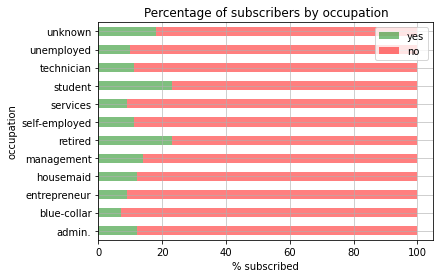

In [9]:
### subscriber by job type
yn = dataset[['job','y']].groupby(['job','y']).size().reset_index(name='counts')
yed = dataset.groupby(['job']).size().reset_index(name='counts')
jed = yn.set_index('job').join(yed.set_index('job'), on='job', how='left', lsuffix='_caller', rsuffix='_other')
jed = jed.assign(perc = (jed['counts_caller']/jed['counts_other']) * 100)
jed = jed.round()
jed = jed.sort_values('y', ascending=True).pivot(columns='y', values='perc')
jed[['yes','no']].plot.barh(stacked=True, color=['Green','Red'], alpha=0.5)
plt.title('Percentage of subscribers by occupation')
plt.ylabel('occupation')
plt.xlabel('% subscribed')
plt.legend()
plt.grid(alpha=0.75)

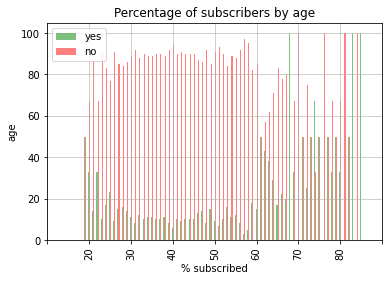

In [10]:
### subscriber by age
yn = dataset[['age','y']].groupby(['age','y']).size().reset_index(name='counts')
yed = dataset.groupby(['age']).size().reset_index(name='counts')
jed = yn.set_index('age').join(yed.set_index('age'), on='age', how='left', lsuffix='_caller', rsuffix='_other')
jed = jed.assign(perc = (jed['counts_caller']/jed['counts_other']) * 100)
jed = jed.round()
jed = jed.sort_values('y', ascending=True).pivot(columns='y', values='perc')
jed[['yes','no']].plot.bar(color=['Green','Red'], alpha=0.5)
plt.title('Percentage of subscribers by age')
plt.ylabel('age')
plt.xlabel('% subscribed')
plt.legend()
plt.xticks([-9,1,11,21,31,41,51,61,71])
plt.grid(alpha=0.75)

## Training

Upon completing the intial exploratory data analysis, I uploaded the dataset to H2O to run it through a GBM model. The model was trained on eight of the columns in the dataset: age, job, marital, education, default, balance, housing, loan

In [11]:
dataset = DataFrame("BANK_MARKETING_DATA").select(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'y'])
dataset.head()

   age       job marital  education default balance housing loan    y
0   19   student  single    unknown      no       0      no   no   no
1   20   student  single  secondary      no     502      no   no  yes
2   20   student  single  secondary      no     291      no   no   no
3   20   student  single  secondary      no    1191      no   no   no
4   21  services  single  secondary      no     361      no   no   no
5   21  services  single  secondary      no    1903     yes   no   no
6   21   student  single  secondary      no       6      no   no   no
7   19   student  single  secondary      no     302      no   no  yes
8   19   student  single    unknown      no    1169      no   no   no
9   19   student  single    primary      no     103      no   no  yes

Now we must initialize h2o cluster (locally) and prepare the training dataset

In [12]:
h2o.init()
dataset_hf=h2o.H2OFrame(dataset.to_pandas())

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_292"; OpenJDK Runtime Environment (build 1.8.0_292-8u292-b10-0ubuntu1~20.04-b10); OpenJDK 64-Bit Server VM (build 25.292-b10, mixed mode)
  Starting server from /opt/conda/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpp5ddqqx6
  JVM stdout: /tmp/tmpp5ddqqx6/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpp5ddqqx6/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,13 days
H2O_cluster_name:,H2O_from_python_unknownUser_f676cn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,875 Mb
H2O_cluster_total_cores:,6
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


We split the training dataset

In [13]:
train,test = dataset_hf.split_frame(ratios=[.7])

Identify predictors and response

In [14]:
x = train.columns
y = 'y'
x.remove(y)

For binary classification, response should be a factor

In [15]:
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

We initally train with 50 ntrees, 2 max depth and 2 min rows. Then we evaluate the predictions with the other split.

In [16]:
model = H2OGradientBoostingEstimator(categorical_encoding = 'auto', ntrees = 50, max_depth = 2, min_rows = 2, learn_rate = 0.1)
model.train(x = x, y = y, training_frame = train)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1634771229108_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,5396.0,2.0,2.0,2.0,3.0,4.0,3.94




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.09241102086743708
RMSE: 0.3039918105269237
LogLoss: 0.3221789856642488
Mean Per-Class Error: 0.34484021632251727
AUC: 0.7166819075712881
AUCPR: 0.30149156071804367
Gini: 0.43336381514257627

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14801465297054048: 


,,no,yes,Error,Rate
0,no,2430.0,395.0,0.1398,(395.0/2825.0)
1,yes,210.0,150.0,0.5833,(210.0/360.0)
2,Total,2640.0,545.0,0.19,(605.0/3185.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.148015,0.331492,152.0
1,max f2,0.097083,0.453529,266.0
2,max f0point5,0.210040,0.339958,85.0
3,max accuracy,0.341964,0.892308,25.0
4,max precision,0.769103,1.000000,0.0
5,max recall,0.044795,1.000000,388.0
6,max specificity,0.769103,1.000000,0.0
7,max absolute_mcc,0.148015,0.232753,152.0
8,max min_per_class_accuracy,0.116321,0.647222,218.0
9,max mean_per_class_accuracy,0.112421,0.655160,228.0



Gains/Lift Table: Avg response rate: 11.30 %, avg score: 11.31 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010989,0.334913,6.319444,6.319444,0.714286,0.444646,0.714286,0.444646,0.069444,0.069444,531.944444,531.944444,0.065905
1,2,0.020094,0.299640,3.050766,4.838325,0.344828,0.314966,0.546875,0.385885,0.027778,0.097222,205.076628,383.832465,0.086957
2,3,0.030141,0.262357,3.041233,4.239294,0.343750,0.282152,0.479167,0.351307,0.030556,0.127778,204.123264,323.929398,0.110079
3,4,0.040188,0.219073,2.488281,3.801541,0.281250,0.242531,0.429688,0.324113,0.025000,0.152778,148.828125,280.154080,0.126937
4,5,0.050235,0.200930,2.764757,3.594184,0.312500,0.210422,0.406250,0.301375,0.027778,0.180556,176.475694,259.418403,0.146927
5,6,0.100157,0.168008,1.891859,2.745690,0.213836,0.180421,0.310345,0.241088,0.094444,0.275000,89.185884,174.568966,0.197124
6,7,0.150078,0.154766,1.947502,2.480184,0.220126,0.160319,0.280335,0.214221,0.097222,0.372222,94.750175,148.018364,0.250452
7,8,0.200942,0.138272,1.529150,2.239453,0.172840,0.146468,0.253125,0.197071,0.077778,0.450000,52.914952,123.945312,0.280796
8,9,0.301099,0.122836,1.137104,1.872770,0.128527,0.129058,0.211679,0.174447,0.113889,0.563889,13.710380,87.276967,0.296278
9,10,0.412559,0.113104,1.046714,1.649596,0.118310,0.116787,0.186454,0.158869,0.116667,0.680556,4.671362,64.959623,0.302148




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2021-10-20 23:07:34,0.235 sec,0.0,0.316629,0.352803,0.500000,0.113030,1.000000,0.886970
1,,2021-10-20 23:07:34,0.448 sec,1.0,0.315618,0.349999,0.593959,0.186546,3.269626,0.418210
2,,2021-10-20 23:07:34,0.492 sec,2.0,0.314849,0.348145,0.620249,0.202659,3.269626,0.248352
3,,2021-10-20 23:07:34,0.525 sec,3.0,0.314185,0.346575,0.637282,0.209732,3.538889,0.211931
4,,2021-10-20 23:07:34,0.560 sec,4.0,0.313623,0.345362,0.642006,0.221675,3.538889,0.220722
5,,2021-10-20 23:07:34,0.598 sec,5.0,0.313150,0.344319,0.641833,0.221317,3.538889,0.220722
6,,2021-10-20 23:07:34,0.629 sec,6.0,0.312740,0.343458,0.643488,0.223367,3.538889,0.257143
7,,2021-10-20 23:07:35,0.659 sec,7.0,0.312394,0.342681,0.641896,0.222292,3.538889,0.220722
8,,2021-10-20 23:07:35,0.695 sec,8.0,0.311949,0.341421,0.655407,0.229760,3.811111,0.257143
9,,2021-10-20 23:07:35,0.725 sec,9.0,0.311596,0.340370,0.665393,0.234323,3.811111,0.204396



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,age,45.816795,1.000000,0.381117
1,job,29.024767,0.633496,0.241436
2,balance,21.600380,0.471451,0.179678
3,housing,9.043016,0.197373,0.075222
4,loan,5.382477,0.117478,0.044773
5,marital,4.243920,0.092628,0.035302
6,default,3.515159,0.076722,0.029240
7,education,1.590603,0.034717,0.013231


In our first training the accuracy is 0,87 so we will try with other hyperparameters to find a better result.

Let's try with a setting of ntrees = 100, max_depth = 5 and min_rows = 3.

In [17]:
model = H2OGradientBoostingEstimator(categorical_encoding = 'auto', ntrees = 100, max_depth = 5, min_rows = 3, learn_rate = 0.1)
model.train(x = x, y = y, training_frame = train)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1634771229108_53


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,100.0,100.0,32408.0,5.0,5.0,5.0,8.0,32.0,21.11




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.06561578078930991
RMSE: 0.2561557744602099
LogLoss: 0.2310549817787865
Mean Per-Class Error: 0.18321533923303834
AUC: 0.9120417895771878
AUCPR: 0.7041721701407567
Gini: 0.8240835791543757

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24532157360099474: 


,,no,yes,Error,Rate
0,no,2755.0,70.0,0.0248,(70.0/2825.0)
1,yes,164.0,196.0,0.4556,(164.0/360.0)
2,Total,2919.0,266.0,0.0735,(234.0/3185.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.245322,0.626198,144.0
1,max f2,0.171585,0.662927,191.0
2,max f0point5,0.312354,0.729962,113.0
3,max accuracy,0.312354,0.929042,113.0
4,max precision,0.963192,1.000000,0.0
5,max recall,0.024200,1.000000,371.0
6,max specificity,0.963192,1.000000,0.0
7,max absolute_mcc,0.264571,0.596599,135.0
8,max min_per_class_accuracy,0.128064,0.808333,229.0
9,max mean_per_class_accuracy,0.147006,0.816785,210.0



Gains/Lift Table: Avg response rate: 11.30 %, avg score: 11.32 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010047,0.720754,8.847222,8.847222,1.000000,0.830932,1.000000,0.830932,0.088889,0.088889,784.722222,784.722222,0.088889
1,2,0.020094,0.571866,8.847222,8.847222,1.000000,0.643553,1.000000,0.737243,0.088889,0.177778,784.722222,784.722222,0.177778
2,3,0.030141,0.446468,8.294271,8.662905,0.937500,0.495803,0.979167,0.656763,0.083333,0.261111,729.427083,766.290509,0.260403
3,4,0.040188,0.383992,7.464844,8.363390,0.843750,0.417047,0.945312,0.596834,0.075000,0.336111,646.484375,736.338976,0.333633
4,5,0.050235,0.326696,6.635417,8.017795,0.750000,0.355346,0.906250,0.548536,0.066667,0.402778,563.541667,701.779514,0.397468
5,6,0.100157,0.223461,3.616789,5.824190,0.408805,0.264528,0.658307,0.406977,0.180556,0.583333,261.678896,482.419018,0.544749
6,7,0.150078,0.178743,2.281359,4.645717,0.257862,0.199069,0.525105,0.337820,0.113889,0.697222,128.135919,364.571711,0.616868
7,8,0.200000,0.147965,1.224144,3.791667,0.138365,0.163398,0.428571,0.294283,0.061111,0.758333,22.414396,279.166667,0.629484
8,9,0.300157,0.116064,0.970698,2.850360,0.109718,0.130830,0.322176,0.239741,0.097222,0.855556,-2.930164,185.036030,0.626175
9,10,0.401570,0.097039,0.712160,2.310377,0.080495,0.106085,0.261142,0.205988,0.072222,0.927778,-28.783970,131.037703,0.593265




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2021-10-20 23:07:40,0.056 sec,0.0,0.316629,0.352803,0.500000,0.113030,1.000000,0.886970
1,,2021-10-20 23:07:40,0.129 sec,1.0,0.314112,0.345679,0.697800,0.269837,4.937984,0.252119
2,,2021-10-20 23:07:40,0.167 sec,2.0,0.312221,0.340793,0.714855,0.284134,3.953014,0.234537
3,,2021-10-20 23:07:40,0.223 sec,3.0,0.310687,0.337049,0.714938,0.282780,3.953014,0.233281
4,,2021-10-20 23:07:40,0.275 sec,4.0,0.309227,0.333557,0.732753,0.300269,4.054977,0.236735
5,,2021-10-20 23:07:40,0.298 sec,5.0,0.307889,0.330494,0.734046,0.308890,5.738739,0.203454
6,,2021-10-20 23:07:40,0.344 sec,6.0,0.306799,0.327964,0.735663,0.310309,6.066667,0.195918
7,,2021-10-20 23:07:40,0.374 sec,7.0,0.305604,0.325452,0.738202,0.319548,6.635417,0.195290
8,,2021-10-20 23:07:40,0.394 sec,8.0,0.304651,0.323246,0.745466,0.324594,6.635417,0.194662
9,,2021-10-20 23:07:40,0.416 sec,9.0,0.303618,0.320879,0.749260,0.330862,6.358941,0.191209



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,balance,134.381851,1.000000,0.280416
1,job,129.786362,0.965803,0.270827
2,age,117.500580,0.874378,0.245190
3,education,39.649887,0.295054,0.082738
4,marital,26.871912,0.199967,0.056074
5,housing,20.327667,0.151268,0.042418
6,loan,8.485096,0.063142,0.017706
7,default,2.219823,0.016519,0.004632


The accuracy has increased significantly. Let's try now with a setting of ntrees = 180, max_depth = 10 and min_rows = 5.

In [18]:
model = H2OGradientBoostingEstimator(categorical_encoding = 'auto', ntrees = 180, max_depth = 10, min_rows = 5, learn_rate = 0.1)
model.train(x = x, y = y, training_frame = train)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1634771229108_155


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,180.0,180.0,324269.0,0.0,10.0,9.894444,1.0,275.0,138.61667




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.002345784811966503
RMSE: 0.04843330271586384
LogLoss: 0.018213540845587448
Mean Per-Class Error: 0.0015929203539822856
AUC: 0.9999680432645034
AUCPR: 0.9997511798903187
Gini: 0.9999360865290068

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4061349918818934: 


,,no,yes,Error,Rate
0,no,2818.0,7.0,0.0025,(7.0/2825.0)
1,yes,1.0,359.0,0.0028,(1.0/360.0)
2,Total,2819.0,366.0,0.0025,(8.0/3185.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.406135,0.988981,183.0
1,max f2,0.310966,0.995025,184.0
2,max f0point5,0.680420,0.995475,176.0
3,max accuracy,0.680420,0.997488,176.0
4,max precision,0.997746,1.000000,0.0
5,max recall,0.310966,1.000000,184.0
6,max specificity,0.997746,1.000000,0.0
7,max absolute_mcc,0.406135,0.987606,183.0
8,max min_per_class_accuracy,0.406135,0.997222,183.0
9,max mean_per_class_accuracy,0.310966,0.998407,184.0



Gains/Lift Table: Avg response rate: 11.30 %, avg score: 11.31 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010047,0.987514,8.847222,8.847222,1.000000,0.991873,1.000000,0.991873,0.088889,0.088889,784.722222,784.722222,0.088889
1,2,0.020094,0.980908,8.847222,8.847222,1.000000,0.983776,1.000000,0.987824,0.088889,0.177778,784.722222,784.722222,0.177778
2,3,0.030141,0.975594,8.847222,8.847222,1.000000,0.978164,1.000000,0.984604,0.088889,0.266667,784.722222,784.722222,0.266667
3,4,0.040188,0.968079,8.847222,8.847222,1.000000,0.971921,1.000000,0.981433,0.088889,0.355556,784.722222,784.722222,0.355556
4,5,0.050235,0.959144,8.847222,8.847222,1.000000,0.962925,1.000000,0.977732,0.088889,0.444444,784.722222,784.722222,0.444444
5,6,0.100157,0.856403,8.847222,8.847222,1.000000,0.924390,1.000000,0.951145,0.441667,0.886111,784.722222,784.722222,0.886111
6,7,0.150078,0.039845,2.281359,6.663180,0.257862,0.262386,0.753138,0.722039,0.113889,1.000000,128.135919,566.317992,0.958230
7,8,0.200000,0.022007,0.000000,5.000000,0.000000,0.029114,0.565149,0.549079,0.000000,1.000000,-100.000000,400.000000,0.901947
8,9,0.300157,0.009902,0.000000,3.331590,0.000000,0.014432,0.376569,0.370677,0.000000,1.000000,-100.000000,233.158996,0.789027
9,10,0.400000,0.005747,0.000000,2.500000,0.000000,0.007563,0.282575,0.280041,0.000000,1.000000,-100.000000,150.000000,0.676460




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2021-10-20 23:08:14,0.022 sec,0.0,0.316629,0.352803,0.500000,0.113030,1.000000,0.886970
1,,2021-10-20 23:08:14,0.067 sec,1.0,0.309739,0.333742,0.837174,0.428678,6.695195,0.140345
2,,2021-10-20 23:08:14,0.103 sec,2.0,0.303855,0.319447,0.866352,0.489331,7.238636,0.133752
3,,2021-10-20 23:08:14,0.126 sec,3.0,0.298608,0.307746,0.886887,0.537838,8.066585,0.129042
4,,2021-10-20 23:08:14,0.149 sec,4.0,0.294013,0.298226,0.897377,0.578070,8.017795,0.122135
5,,2021-10-20 23:08:14,0.175 sec,5.0,0.289309,0.288689,0.908160,0.610062,8.294271,0.106750
6,,2021-10-20 23:08:14,0.200 sec,6.0,0.284962,0.280299,0.914292,0.630462,8.294271,0.099215
7,,2021-10-20 23:08:14,0.240 sec,7.0,0.281391,0.273528,0.919167,0.645362,8.570747,0.089796
8,,2021-10-20 23:08:14,0.264 sec,8.0,0.276683,0.264855,0.928183,0.676391,8.017795,0.085400
9,,2021-10-20 23:08:14,0.291 sec,9.0,0.272422,0.257291,0.935846,0.704421,8.570747,0.081005



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,balance,359.684143,1.000000,0.333245
1,age,295.805573,0.822404,0.274062
2,job,215.230209,0.598387,0.199409
3,education,83.196190,0.231303,0.077081
4,marital,61.748997,0.171676,0.057210
5,housing,47.474773,0.131990,0.043985
6,loan,12.630203,0.035115,0.011702
7,default,3.569776,0.009925,0.003307


## Evaluation

Evaluate performance

In [19]:
perf=model.model_performance(test)
perf


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.12786518644618283
RMSE: 0.35758241909549027
LogLoss: 0.6218023956798786
Mean Per-Class Error: 0.4245724857935773
AUC: 0.5806686930091186
AUCPR: 0.16062029210893594
Gini: 0.16133738601823722

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.016132839263127714: 


,,no,yes,Error,Rate
0,no,783.0,392.0,0.3336,(392.0/1175.0)
1,yes,83.0,78.0,0.5155,(83.0/161.0)
2,Total,866.0,470.0,0.3555,(475.0/1336.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.016133,0.247227,307.0
1,max f2,0.000356,0.419372,394.0
2,max f0point5,0.047863,0.212245,227.0
3,max accuracy,0.998054,0.880240,0.0
4,max precision,0.998054,1.000000,0.0
5,max recall,0.000090,1.000000,398.0
6,max specificity,0.998054,1.000000,0.0
7,max absolute_mcc,0.046044,0.115461,230.0
8,max min_per_class_accuracy,0.007959,0.553191,342.0
9,max mean_per_class_accuracy,0.016133,0.575428,307.0



Gains/Lift Table: Avg response rate: 12.05 %, avg score:  6.35 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010479,0.892235,1.778172,1.778172,0.214286,0.942741,0.214286,0.942741,0.018634,0.018634,77.817214,77.817214,0.009272
1,2,0.020210,0.728431,1.276636,1.536692,0.153846,0.802920,0.185185,0.875420,0.012422,0.031056,27.663641,53.669197,0.012332
2,3,0.030689,0.622526,1.778172,1.619149,0.214286,0.670433,0.195122,0.805424,0.018634,0.049689,77.817214,61.914861,0.021604
3,4,0.040419,0.501963,2.553273,1.844030,0.307692,0.549401,0.222222,0.743789,0.024845,0.074534,155.327281,84.403037,0.038789
4,5,0.050150,0.382105,0.000000,1.486233,0.000000,0.437498,0.179104,0.684359,0.000000,0.074534,-100.000000,48.623343,0.027726
5,6,0.100299,0.172673,1.362381,1.424307,0.164179,0.262627,0.171642,0.473493,0.068323,0.142857,36.238064,42.430704,0.048389
6,7,0.150449,0.083858,1.610086,1.486233,0.194030,0.125363,0.179104,0.357450,0.080745,0.223602,61.008621,48.623343,0.083177
7,8,0.200599,0.046465,1.981645,1.610086,0.238806,0.062403,0.194030,0.283688,0.099379,0.322981,98.164457,61.008621,0.139152
8,9,0.300150,0.022193,0.748704,1.324391,0.090226,0.032455,0.159601,0.200362,0.074534,0.397516,-25.129594,32.439089,0.110707
9,10,0.400449,0.011835,1.176601,1.287374,0.141791,0.016267,0.155140,0.154252,0.118012,0.515528,17.660146,28.737447,0.130847


Extract feature interactions:

In [20]:
feature_interactions = model.feature_interaction()
feature_interactions


Interaction Depth 0: 


,,interaction,gain,fscore,wfscore,average_wfscore,average_gain,expected_gain,gain_rank,fscore_rank,wfscore_rank,avg_wfscore_rank,avg_gain_rank,expected_gain_rank,average_rank,average_tree_index,average_tree_depth
0,,loan,12.244593,393.0,46.467818,0.118239,0.031157,3.211307,7.0,7.0,7.0,2.0,8.0,6.0,6.166667,87.531807,6.732824
1,,balance,359.360232,7649.0,633.085719,0.082767,0.046981,27.128469,1.0,1.0,1.0,3.0,1.0,1.0,1.333333,91.330370,6.745326
2,,education,83.193832,2027.0,92.132811,0.045453,0.041043,3.103049,4.0,4.0,4.0,7.0,3.0,7.0,4.833333,88.966453,7.003947
3,,default,3.569792,90.0,18.655259,0.207281,0.039664,0.730037,8.0,8.0,8.0,1.0,5.0,8.0,6.333333,85.266667,5.377778
4,,marital,61.748953,1527.0,72.186814,0.047274,0.040438,3.719842,5.0,5.0,5.0,6.0,4.0,5.0,5.000000,89.832351,6.905697
5,,age,265.115025,7080.0,563.932501,0.079651,0.037446,14.679961,2.0,2.0,2.0,4.0,7.0,2.0,3.166667,92.665960,6.953107
6,,housing,47.474843,1243.0,53.972999,0.043422,0.038194,7.181541,6.0,6.0,6.0,8.0,6.0,4.0,6.000000,91.929204,7.165728
7,,job,215.229426,4762.0,237.814444,0.049940,0.045197,13.774520,3.0,3.0,3.0,5.0,2.0,3.0,3.166667,88.617178,6.665687



Interaction Depth 1: 


,,interaction,gain,fscore,wfscore,average_wfscore,average_gain,expected_gain,gain_rank,fscore_rank,wfscore_rank,avg_wfscore_rank,avg_gain_rank,expected_gain_rank,average_rank,average_tree_index,average_tree_depth
0,,age|education,107.744768,1287.0,78.258400,0.060807,0.083718,4.107774,6.0,6.0,6.0,13.0,16.0,12.0,9.833333,89.462315,7.034188
1,,default|job,7.191462,67.0,9.224804,0.137684,0.107335,0.496407,22.0,23.0,20.0,8.0,4.0,23.0,16.666667,81.402985,5.119403
2,,balance|housing,62.904002,607.0,28.069388,0.046243,0.103631,8.441957,12.0,13.0,14.0,18.0,7.0,6.0,11.666667,91.199341,7.082372
3,,age|housing,61.711155,735.0,31.090738,0.042300,0.083961,6.992169,13.0,12.0,12.0,20.0,15.0,7.0,13.166667,92.376871,7.368707
4,,job|job,37.932384,443.0,10.685714,0.024121,0.085626,1.210979,15.0,15.0,19.0,30.0,14.0,18.0,18.500000,79.693002,6.751693
5,,age|balance,306.085014,3299.0,166.108950,0.050351,0.092781,16.185265,1.0,1.0,3.0,14.0,12.0,2.0,5.500000,91.986056,7.120036
6,,marital|marital,0.085789,6.0,0.076923,0.012821,0.014298,0.001431,33.0,33.0,33.0,32.0,32.0,33.0,32.666667,120.000000,8.166667
7,,education|loan,2.555785,76.0,2.303925,0.030315,0.033629,0.286632,26.0,22.0,27.0,26.0,30.0,27.0,26.333333,91.526316,7.526316
8,,balance|default,3.907576,26.0,5.034537,0.193636,0.150291,0.809067,24.0,28.0,24.0,2.0,2.0,20.0,16.666667,62.807692,5.846154
9,,balance|loan,17.673995,159.0,17.983673,0.113105,0.111157,2.039583,17.0,21.0,16.0,10.0,3.0,17.0,14.000000,78.201258,6.490566



See the whole table with table.as_data_frame()

Interaction Depth 2: 


,,interaction,gain,fscore,wfscore,average_wfscore,average_gain,expected_gain,gain_rank,fscore_rank,wfscore_rank,avg_wfscore_rank,avg_gain_rank,expected_gain_rank,average_rank,average_tree_index,average_tree_depth
0,,age|housing|job,59.107466,565.0,20.887912,0.036970,0.104615,5.501848,22.0,15.0,14.0,55.0,57.0,11.0,29.000000,95.699115,7.205310
1,,balance|marital|marital,0.563165,7.0,0.095761,0.013680,0.080452,0.005048,77.0,76.0,84.0,82.0,70.0,82.0,78.500000,100.428571,7.714286
2,,default|job|marital,1.357379,31.0,4.098901,0.132223,0.043786,0.148295,71.0,58.0,42.0,16.0,81.0,62.0,55.000000,97.903226,6.000000
3,,education|education|loan,0.036783,1.0,0.010989,0.010989,0.036783,0.000404,89.0,89.0,91.0,85.0,84.0,89.0,87.833333,70.000000,9.000000
4,,education|job|loan,5.922175,61.0,1.296703,0.021257,0.097085,0.396918,47.0,44.0,62.0,74.0,63.0,52.0,57.000000,83.655738,7.442623
5,,balance|default|job,6.161769,39.0,5.339717,0.136916,0.157994,0.712885,46.0,52.0,37.0,14.0,22.0,41.0,35.333333,62.820513,6.307692
6,,balance|job|loan,36.552859,146.0,13.061225,0.089460,0.250362,3.010466,27.0,36.0,25.0,27.0,6.0,20.0,23.500000,77.835616,6.301370
7,,age|age|job,171.544467,1584.0,93.134066,0.058797,0.108298,9.166404,5.0,4.0,4.0,34.0,55.0,5.0,17.833333,95.358586,7.001894
8,,education|housing|loan,0.079494,9.0,0.080377,0.008931,0.008833,0.000635,87.0,71.0,85.0,90.0,92.0,88.0,85.500000,97.222222,7.777778
9,,education|job|marital,45.953366,297.0,8.353532,0.028126,0.154725,1.657542,23.0,25.0,31.0,65.0,24.0,30.0,33.000000,91.033670,6.919192



See the whole table with table.as_data_frame()

Interaction Depth 3: 


,,interaction,gain,fscore,wfscore,average_wfscore,average_gain,expected_gain,gain_rank,fscore_rank,wfscore_rank,avg_wfscore_rank,avg_gain_rank,expected_gain_rank,average_rank,average_tree_index,average_tree_depth
0,,education|education|job|marital,0.438830,18.0,0.178336,0.009908,0.024379,0.002471,146.0,101.0,144.0,165.0,173.0,166.0,149.166667,118.111111,6.833333
1,,job|job|job|job,0.027077,1.0,0.005338,0.005338,0.027077,0.000145,179.0,173.0,184.0,182.0,168.0,180.0,177.666667,37.000000,8.000000
2,,balance|balance|balance|job,223.703671,1236.0,81.684459,0.066088,0.180990,12.084203,2.0,3.0,2.0,56.0,75.0,2.0,23.333333,96.846278,6.485437
3,,default|housing|job|job,0.595118,2.0,0.006907,0.003454,0.297559,0.002241,141.0,164.0,183.0,185.0,31.0,168.0,145.333333,88.500000,5.000000
4,,age|age|default|loan,0.354472,4.0,0.761381,0.190345,0.088618,0.057281,152.0,149.0,108.0,9.0,139.0,122.0,113.166667,61.250000,7.250000
5,,education|education|housing|job,0.494980,6.0,0.046154,0.007692,0.082497,0.002548,144.0,137.0,166.0,177.0,141.0,165.0,155.000000,71.166667,7.833333
6,,age|loan|marital|marital,0.002474,1.0,0.033595,0.033595,0.002474,0.000083,183.0,174.0,168.0,101.0,183.0,182.0,165.166667,112.000000,8.000000
7,,age|age|age|default,2.131843,12.0,1.625118,0.135426,0.177654,0.325563,119.0,116.0,82.0,21.0,79.0,88.0,84.166667,94.166667,6.333333
8,,age|education|job|loan,17.569744,81.0,2.118367,0.026153,0.216910,1.097144,55.0,59.0,75.0,119.0,53.0,51.0,68.666667,75.864198,7.543210
9,,age|housing|job|job,25.637413,182.0,3.812245,0.020946,0.140865,0.506892,46.0,40.0,57.0,138.0,105.0,74.0,76.666667,93.412088,7.296703



See the whole table with table.as_data_frame()

Interaction Depth 4: 


,,interaction,gain,fscore,wfscore,average_wfscore,average_gain,expected_gain,gain_rank,fscore_rank,wfscore_rank,avg_wfscore_rank,avg_gain_rank,expected_gain_rank,average_rank,average_tree_index,average_tree_depth
0,,education|education|job|job|marital,0.607593,9.0,0.060911,0.006768,0.067510,0.004760,238.0,179.0,258.0,288.0,257.0,262.0,247.000000,80.777778,7.333333
1,,age|age|age|education|housing,9.409917,75.0,2.659655,0.035462,0.125466,0.140860,105.0,72.0,78.0,133.0,201.0,152.0,123.500000,104.080000,7.680000
2,,balance|balance|default|housing|job,3.585296,3.0,0.052119,0.017373,1.195099,0.055224,157.0,248.0,265.0,228.0,11.0,187.0,182.666667,20.666667,7.333333
3,,age|education|education|job|marital,3.264630,26.0,0.386499,0.014865,0.125563,0.047710,159.0,118.0,177.0,239.0,200.0,192.0,180.833333,93.500000,7.423077
4,,age|balance|default|housing|loan,9.766930,4.0,0.400000,0.100000,2.441732,1.294331,103.0,228.0,173.0,39.0,4.0,59.0,101.000000,3.000000,7.750000
5,,age|balance|balance|housing|job,141.091526,389.0,11.060597,0.028433,0.362703,5.343263,5.0,12.0,25.0,164.0,64.0,7.0,46.166667,89.159383,7.267352
6,,balance|balance|education|marital|marital,0.332793,6.0,0.080691,0.013448,0.055466,0.005525,252.0,210.0,248.0,244.0,269.0,258.0,246.833333,95.166667,8.666667
7,,age|education|loan|marital|marital,0.259563,3.0,0.021664,0.007221,0.086521,0.001417,258.0,249.0,286.0,285.0,239.0,280.0,266.166667,86.666667,9.000000
8,,balance|education|housing|job|loan,1.689838,9.0,0.075353,0.008373,0.187760,0.006664,194.0,180.0,249.0,280.0,157.0,253.0,218.833333,79.666667,6.777778
9,,balance|job|job|job|job,0.111698,2.0,0.008477,0.004239,0.055849,0.000502,280.0,262.0,298.0,301.0,268.0,292.0,283.500000,37.500000,8.000000



See the whole table with table.as_data_frame()

Interaction Depth 5: 


,,interaction,gain,fscore,wfscore,average_wfscore,average_gain,expected_gain,gain_rank,fscore_rank,wfscore_rank,avg_wfscore_rank,avg_gain_rank,expected_gain_rank,average_rank,average_tree_index,average_tree_depth
0,,age|age|default|housing|job|marital,2.049933,13.0,0.647096,0.049777,0.157687,0.020045,249.0,208.0,175.0,129.0,294.0,318.0,228.833333,125.461538,6.846154
1,,balance|balance|education|education|job|marital,0.021928,4.0,0.038933,0.009733,0.005482,0.000215,442.0,315.0,379.0,383.0,451.0,445.0,402.500000,174.500000,6.000000
2,,age|age|balance|job|job|marital,88.807122,344.0,7.416641,0.021560,0.258160,1.664084,19.0,12.0,29.0,259.0,192.0,40.0,91.833333,83.000000,7.915698
3,,balance|balance|balance|education|housing|job,35.651490,90.0,1.738462,0.019316,0.396128,0.992969,48.0,68.0,108.0,289.0,114.0,72.0,116.500000,82.711111,7.566667
4,,education|housing|job|job|job|marital,2.002592,9.0,0.322763,0.035863,0.222510,0.058907,250.0,233.0,237.0,174.0,223.0,246.0,227.166667,52.111111,8.111111
5,,age|balance|education|job|job|marital,90.518002,234.0,4.576766,0.019559,0.386829,1.768242,16.0,24.0,56.0,286.0,116.0,34.0,88.666667,77.978632,7.824786
6,,age|age|job|job|loan|marital,7.947700,33.0,1.094505,0.033167,0.240839,0.283499,153.0,131.0,135.0,186.0,208.0,145.0,159.666667,62.272727,6.545455
7,,age|age|balance|balance|marital|marital,0.543979,4.0,0.021350,0.005338,0.135995,0.004505,344.0,316.0,407.0,443.0,323.0,380.0,368.833333,102.250000,9.000000
8,,age|balance|balance|default|education|housing,0.328966,4.0,0.051491,0.012873,0.082241,0.003722,375.0,317.0,365.0,347.0,379.0,386.0,361.500000,72.000000,6.250000
9,,age|age|balance|balance|education|housing,15.651942,77.0,1.015699,0.013191,0.203272,0.316539,101.0,76.0,140.0,343.0,237.0,141.0,173.000000,95.389610,7.974026



See the whole table with table.as_data_frame()

Interaction Depth 6: 


,,interaction,gain,fscore,wfscore,average_wfscore,average_gain,expected_gain,gain_rank,fscore_rank,wfscore_rank,avg_wfscore_rank,avg_gain_rank,expected_gain_rank,average_rank,average_tree_index,average_tree_depth
0,,age|balance|balance|balance|balance|balance|balance,24.044789,92.0,13.617583,0.148017,0.261356,2.666922,72.0,61.0,5.0,23.0,274.0,10.0,74.166667,98.032609,7.304348
1,,age|age|age|age|housing|job|loan,10.129211,21.0,1.786499,0.085071,0.482343,1.219766,146.0,181.0,101.0,59.0,142.0,54.0,113.833333,59.142857,6.857143
2,,age|age|age|education|education|housing|marital,1.043239,1.0,0.016954,0.016954,1.043239,0.017688,380.0,518.0,528.0,366.0,51.0,409.0,375.333333,16.000000,9.000000
3,,age|age|age|balance|default|housing|job,12.265717,11.0,0.703297,0.063936,1.115065,1.181232,132.0,256.0,180.0,89.0,43.0,56.0,126.000000,36.000000,8.000000
4,,age|default|education|job|job|loan|marital,0.342211,6.0,0.360126,0.060021,0.057035,0.026633,473.0,328.0,256.0,100.0,515.0,372.0,340.666667,124.000000,6.833333
5,,balance|balance|balance|education|education|job|job,6.401225,9.0,0.077237,0.008582,0.711247,0.069474,205.0,280.0,404.0,504.0,92.0,287.0,295.333333,39.666667,7.888889
6,,age|balance|balance|balance|balance|balance|education,22.051811,53.0,4.939404,0.093196,0.416072,1.616187,80.0,94.0,34.0,50.0,171.0,31.0,76.666667,81.735849,7.867925
7,,age|balance|balance|balance|housing|job|job,103.591131,158.0,2.476923,0.015677,0.655640,3.055375,5.0,32.0,81.0,392.0,101.0,7.0,103.000000,80.234177,7.784810
8,,balance|balance|balance|job|job|job|marital,3.206854,14.0,0.186185,0.013299,0.229061,0.046630,271.0,227.0,321.0,423.0,311.0,321.0,312.333333,75.142857,8.500000
9,,age|balance|balance|balance|housing|job|loan,63.939710,33.0,1.108006,0.033576,1.937567,2.122333,30.0,132.0,138.0,206.0,16.0,18.0,90.000000,41.787879,6.939394



See the whole table with table.as_data_frame()

Interaction Depth 7: 


,,interaction,gain,fscore,wfscore,average_wfscore,average_gain,expected_gain,gain_rank,fscore_rank,wfscore_rank,avg_wfscore_rank,avg_gain_rank,expected_gain_rank,average_rank,average_tree_index,average_tree_depth
0,,age|age|age|age|education|job|job|job,2.935832,22.0,0.368289,0.016740,0.133447,0.031398,308.0,167.0,253.0,399.0,520.0,385.0,338.666667,81.772727,8.363636
1,,age|age|age|balance|balance|balance|education|job,35.571926,176.0,7.821978,0.044443,0.202113,1.495803,48.0,15.0,6.0,146.0,432.0,29.0,112.666667,88.107955,8.011364
2,,age|age|age|age|balance|balance|balance|marital,0.719742,12.0,0.492308,0.041026,0.059979,0.013793,476.0,257.0,217.0,154.0,618.0,466.0,364.666667,98.333333,7.666667
3,,balance|balance|education|job|job|job|loan|marital,0.520797,4.0,0.029199,0.007300,0.130199,0.002590,520.0,417.0,562.0,626.0,525.0,609.0,543.166667,81.500000,8.500000
4,,age|balance|balance|balance|balance|balance|default|loan,0.668558,1.0,0.061852,0.061852,0.668558,0.041352,485.0,598.0,477.0,99.0,132.0,358.0,358.166667,37.000000,8.000000
5,,balance|balance|balance|education|education|job|job|loan,0.524402,1.0,0.013815,0.013815,0.524402,0.007244,517.0,599.0,628.0,463.0,179.0,530.0,486.000000,27.000000,7.000000
6,,age|age|age|age|age|age|job|marital,1.649058,16.0,1.823234,0.113952,0.103066,0.122179,378.0,212.0,78.0,42.0,570.0,241.0,253.500000,133.312500,8.312500
7,,age|age|default|education|housing|job|job|loan,1.961811,1.0,0.027630,0.027630,1.961811,0.054204,365.0,600.0,571.0,254.0,30.0,333.0,358.833333,10.000000,8.000000
8,,age|balance|balance|balance|education|housing|job|job,31.930149,70.0,1.037991,0.014828,0.456145,0.796582,56.0,62.0,133.0,430.0,209.0,67.0,159.500000,91.728571,8.357143
9,,age|age|balance|balance|education|job|loan|marital,27.713448,45.0,0.867818,0.019285,0.615854,0.677021,66.0,84.0,150.0,346.0,144.0,78.0,144.666667,71.177778,7.955556



See the whole table with table.as_data_frame()

Interaction Depth 8: 


,,interaction,gain,fscore,wfscore,average_wfscore,average_gain,expected_gain,gain_rank,fscore_rank,wfscore_rank,avg_wfscore_rank,avg_gain_rank,expected_gain_rank,average_rank,average_tree_index,average_tree_depth
0,,age|age|balance|education|education|housing|job|job|loan,4.206051,2.0,0.010675,0.005338,2.103025,0.024349,251.0,534.0,696.0,725.0,35.0,394.0,439.166667,9.500000,9.000000
1,,age|age|age|balance|balance|balance|education|education|job,1.396042,6.0,0.202826,0.033804,0.232674,0.111235,406.0,346.0,300.0,186.0,417.0,236.0,315.166667,85.666667,8.833333
2,,age|age|age|age|age|age|age|default|job,0.006424,2.0,0.433281,0.216640,0.003212,0.001296,777.0,535.0,200.0,14.0,793.0,678.0,499.500000,165.000000,8.500000
3,,age|age|age|age|age|age|balance|balance|education,0.377767,9.0,1.827629,0.203070,0.041974,0.046269,564.0,261.0,42.0,16.0,666.0,320.0,311.500000,92.444444,8.555556
4,,balance|balance|balance|default|housing|job|job|loan|marital,0.030311,1.0,0.228885,0.228885,0.030311,0.006938,726.0,637.0,289.0,13.0,687.0,527.0,479.833333,91.000000,9.000000
5,,age|balance|balance|balance|balance|balance|balance|default|housing,0.210197,1.0,0.030141,0.030141,0.210197,0.006336,630.0,638.0,562.0,210.0,439.0,533.0,502.000000,59.000000,8.000000
6,,age|age|housing|job|job|job|job|loan|marital,0.044137,2.0,0.014443,0.007221,0.022069,0.000319,709.0,536.0,666.0,656.0,704.0,733.0,667.333333,130.000000,8.500000
7,,age|balance|balance|balance|default|education|housing|job|marital,4.519333,5.0,0.183987,0.036797,0.903867,0.202200,233.0,378.0,321.0,172.0,115.0,167.0,231.000000,60.000000,9.000000
8,,age|age|age|age|balance|balance|job|job|loan,9.333221,25.0,0.319309,0.012772,0.373329,0.162789,148.0,124.0,240.0,494.0,295.0,198.0,249.833333,50.640000,8.440000
9,,age|balance|balance|balance|education|housing|job|loan|marital,29.678449,17.0,0.313344,0.018432,1.745791,0.817261,37.0,178.0,241.0,348.0,44.0,42.0,148.333333,61.941176,8.705882



See the whole table with table.as_data_frame()

Interaction Depth 9: 


,,interaction,gain,fscore,wfscore,average_wfscore,average_gain,expected_gain,gain_rank,fscore_rank,wfscore_rank,avg_wfscore_rank,avg_gain_rank,expected_gain_rank,average_rank,average_tree_index,average_tree_depth
0,,age|balance|balance|balance|housing|job|job|job|job|loan,0.011840,1.0,0.017268,0.017268,0.011840,0.000204,733.0,571.0,578.0,316.0,713.0,721.0,605.333333,155.000000,9.0
1,,age|balance|balance|balance|balance|balance|housing|job|job|loan,3.338249,13.0,0.188383,0.014491,0.256788,0.047704,222.0,126.0,230.0,374.0,382.0,253.0,264.500000,88.769231,9.0
2,,age|age|age|age|age|age|balance|balance|balance|job,0.826731,14.0,0.537834,0.038417,0.059052,0.042674,396.0,118.0,79.0,139.0,601.0,266.0,266.500000,127.642857,9.0
3,,age|age|age|balance|housing|job|job|job|loan|marital,1.592578,4.0,0.027630,0.006907,0.398145,0.011693,323.0,326.0,507.0,618.0,264.0,396.0,405.666667,80.000000,9.0
4,,age|age|age|balance|balance|balance|balance|housing|job|marital,3.815204,22.0,0.237049,0.010775,0.173418,0.100822,200.0,80.0,197.0,471.0,472.0,166.0,264.333333,111.727273,9.0
5,,age|age|age|age|education|education|job|loan|marital|marital,0.004790,1.0,0.005338,0.005338,0.004790,0.000026,765.0,572.0,719.0,679.0,759.0,772.0,711.000000,112.000000,9.0
6,,age|age|balance|balance|balance|education|housing|job|marital|marital,2.924967,1.0,0.003454,0.003454,2.924967,0.010102,242.0,573.0,758.0,754.0,13.0,416.0,459.333333,2.000000,9.0
7,,age|age|age|age|age|balance|job|job|job|marital,0.010083,2.0,0.044584,0.022292,0.005041,0.000225,745.0,446.0,434.0,253.0,755.0,718.0,558.500000,145.000000,9.0
8,,balance|balance|balance|balance|balance|balance|education|job|job|...,2.060003,5.0,0.045212,0.009042,0.412001,0.013038,291.0,288.0,429.0,537.0,252.0,387.0,364.000000,70.800000,9.0
9,,age|age|age|balance|balance|balance|balance|education|job|marital,11.277763,59.0,1.353218,0.022936,0.191149,0.173681,59.0,9.0,16.0,248.0,449.0,110.0,148.500000,98.864407,9.0



See the whole table with table.as_data_frame()

Leaf Statistics: 


,,interaction,sum_leaf_values_left,sum_leaf_values_right,sum_leaf_covers_left,sum_leaf_covers_right
0,,balance|balance|education|education|job|marital,-0.200978,0.000000,18.0,0.0
1,,age|age|age|age|balance|balance|balance|marital,-0.112193,-0.135218,24.0,11.0
2,,age|balance|balance|balance|housing|job|job|job|job|loan,-0.101802,-0.100851,18.0,37.0
3,,age|age|balance|job|job|marital,0.517817,1.899694,18.0,45.0
4,,age|balance|balance|balance|balance|balance|housing|job|job|loan,-0.537195,-0.509450,453.0,147.0
5,,age|age|age|age|age|age|balance|balance|balance|job,-0.355150,0.073670,1162.0,551.0
6,,age|age|age|balance|housing|job|job|job|loan|marital,-0.358461,-0.108661,44.0,44.0
7,,age|age|age|balance|balance|balance|balance|housing|job|marital,-0.859801,0.101726,376.0,379.0
8,,age|age|age|age|education|education|job|loan|marital|marital,-0.100586,0.023850,12.0,5.0
9,,age|age|balance|balance|balance|education|housing|job|marital|marital,-0.111893,-0.111073,6.0,5.0



See the whole table with table.as_data_frame()

loan Split Value Histogram: 


,,split_value,count
0,,NaN,393



balance Split Value Histogram: 


,,split_value,count
0,,-1219.5,1
1,,-1217.5,1
2,,-1216.5,1
3,,-1213.5,3
4,,-1211.5,1
5,,-1209.5,1
6,,-1208.5,1
7,,-1207.5,1
8,,-1203.5,1
9,,-1156.5,1



See the whole table with table.as_data_frame()

education Split Value Histogram: 


,,split_value,count
0,,NaN,2027



default Split Value Histogram: 


,,split_value,count
0,,NaN,90



marital Split Value Histogram: 


,,split_value,count
0,,NaN,1527



age Split Value Histogram: 


,,split_value,count
0,,20.5,49
1,,21.5,2
2,,22.0,1
3,,22.5,19
4,,23.0,1
5,,23.5,36
6,,24.0,1
7,,24.5,64
8,,25.0,1
9,,25.5,104



See the whole table with table.as_data_frame()

housing Split Value Histogram: 


,,split_value,count
0,,NaN,1243



job Split Value Histogram: 


,,split_value,count
0,,NaN,4762


[, , , , , , , , , , , , , , , , , , ]

Explain the model:

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GBM_model_python_1634771229108_155


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.016132839263127714: 


,,no,yes,Error,Rate
0,no,783.0,392.0,0.3336,(392.0/1175.0)
1,yes,83.0,78.0,0.5155,(83.0/161.0)
2,Total,866.0,470.0,0.3555,(475.0/1336.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

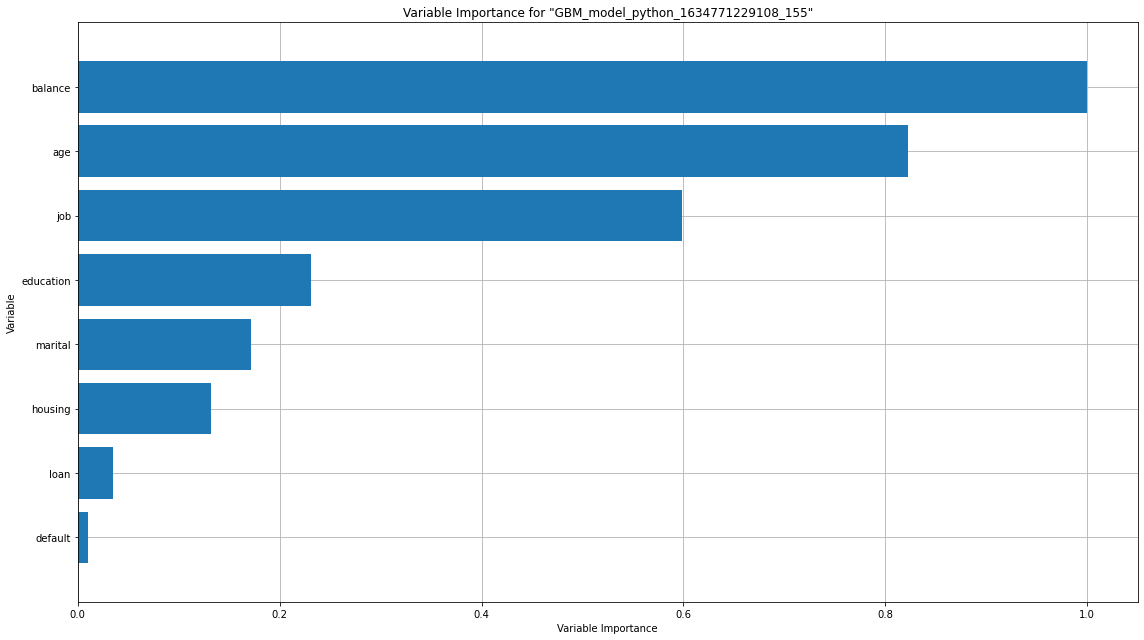

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

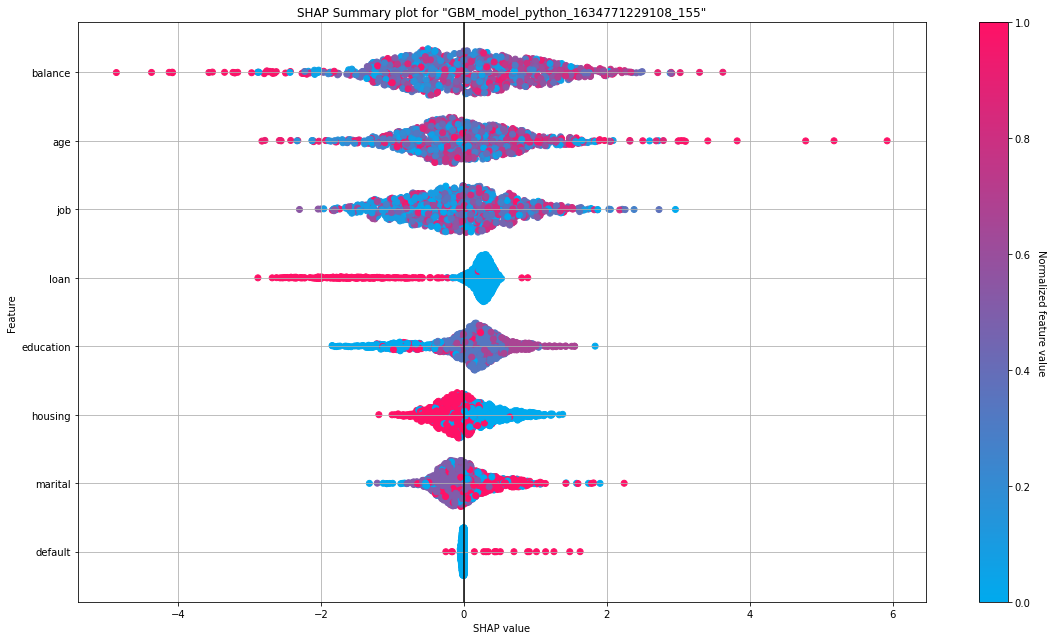

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

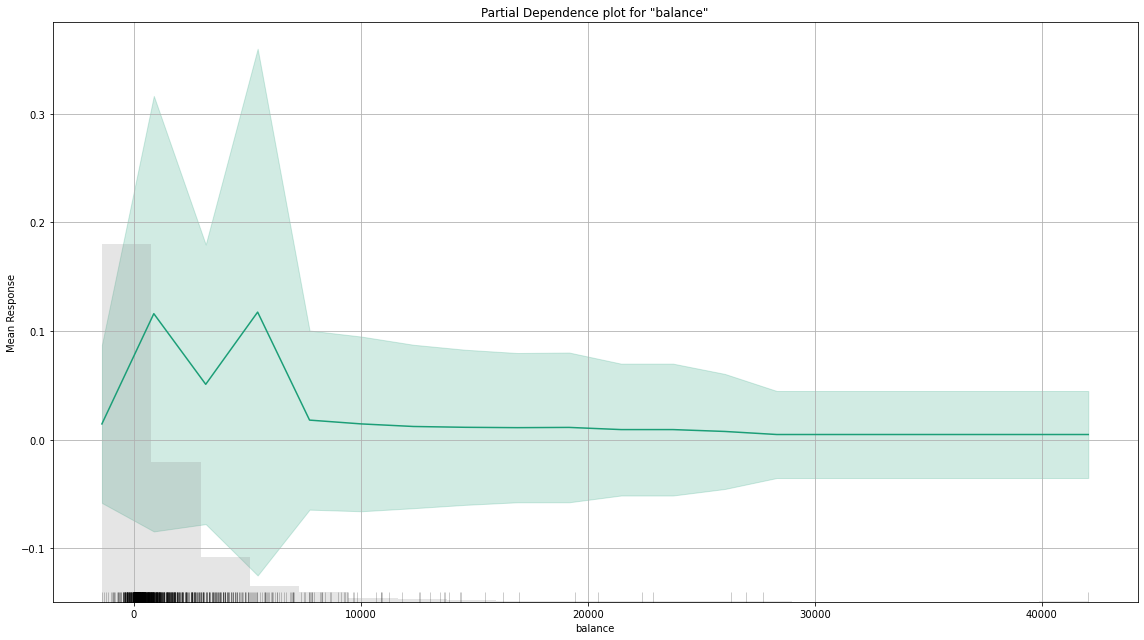

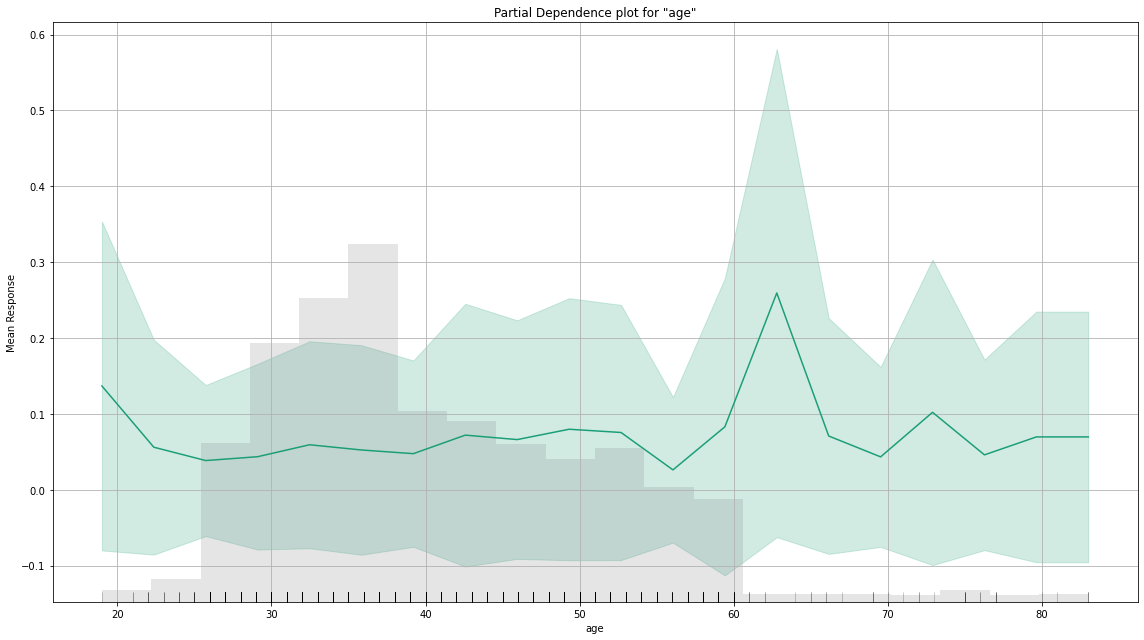

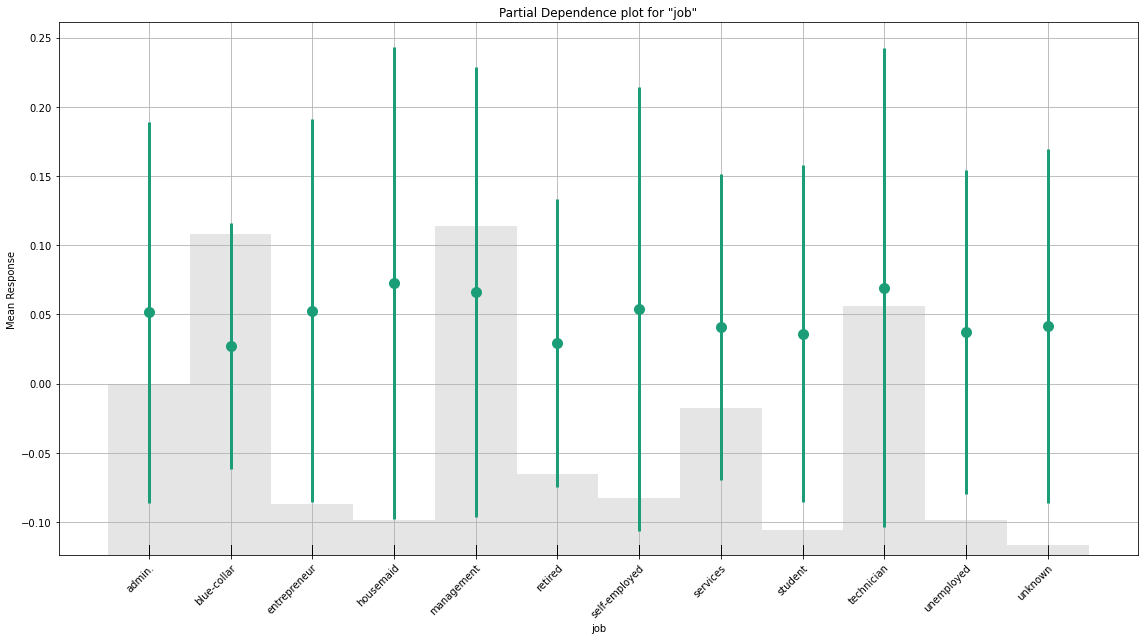

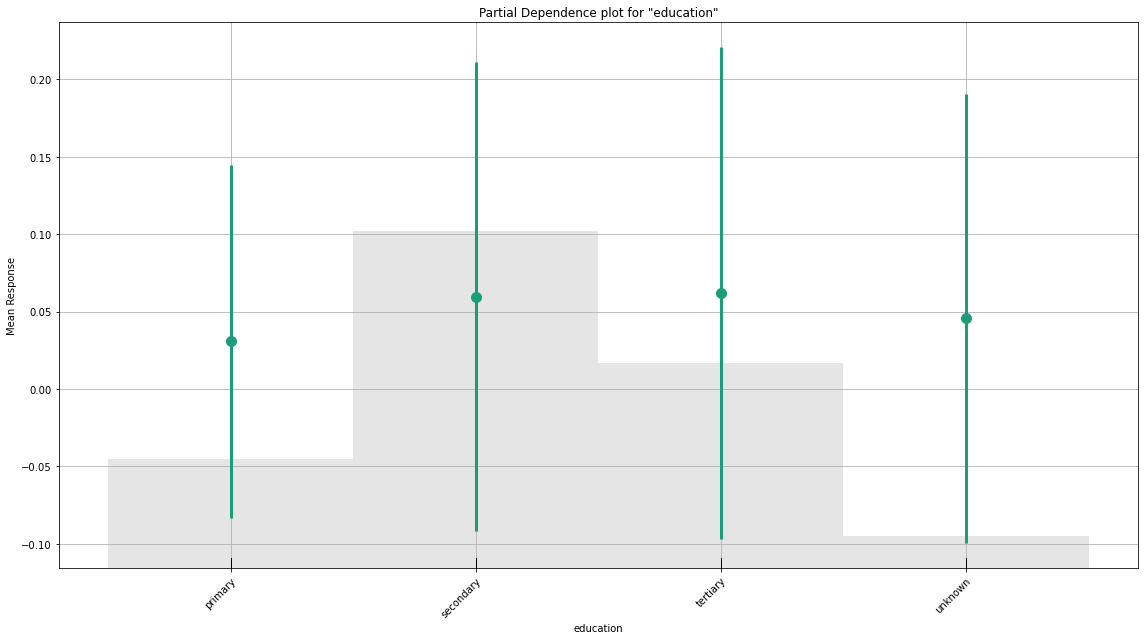

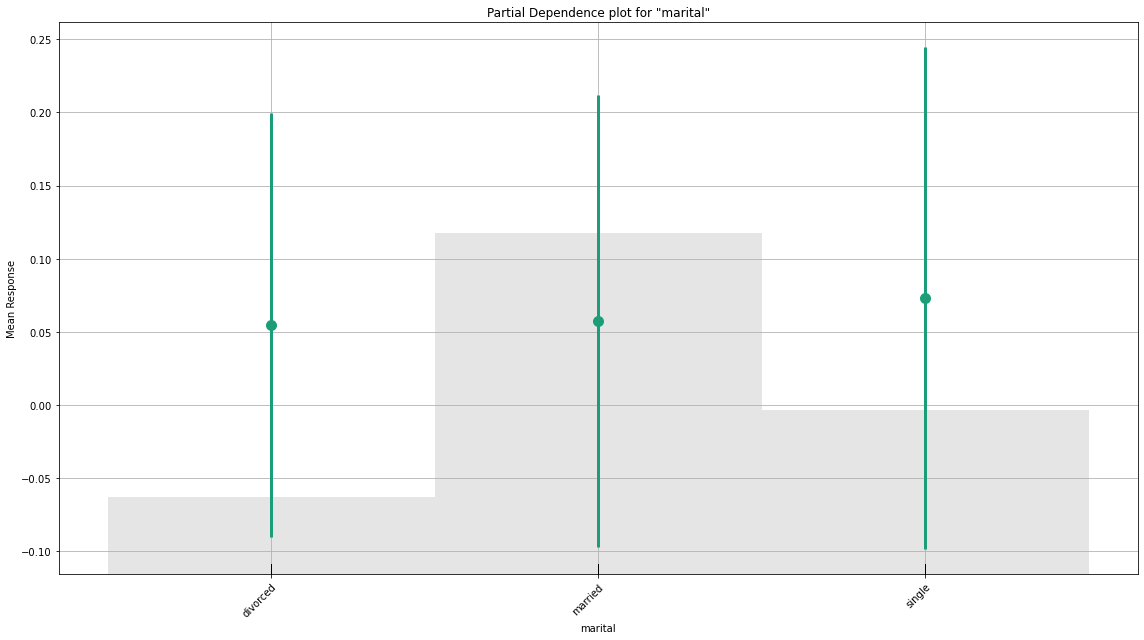

In [21]:
exm=model.explain(test)

The h2o.predict function outputs a data frame with “no” and “yes” prediction columns with the percentage and the prediction column. With this dataframe we can get the accurracy of our model with a confusion matrix.

In [22]:
pred = model.predict(test)
pred

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict,no,yes
no,0.997686,0.00231361
no,0.963168,0.0368323
no,0.998983,0.00101728
no,0.967734,0.0322662
no,0.999095,0.000904538
no,0.999627,0.000373345
no,0.996747,0.0032535
no,0.964727,0.0352729
no,0.987358,0.0126417
no,0.999906,9.3884e-05


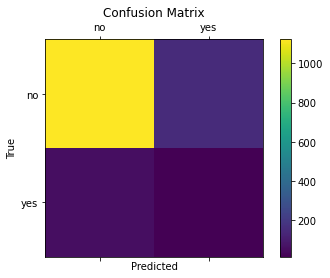

In [23]:
from sklearn.metrics import confusion_matrix
tester = test.as_data_frame()['y'].values
pred_df = pred.as_data_frame()['predict'].values

cm = confusion_matrix(pred_df, tester)
labels = ['no', 'yes']
values = [0,1]
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion Matrix')
fig.colorbar(cax)
ax.set_xticks(values)
ax.set_xticklabels(labels)
ax.set_yticks(values)
ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

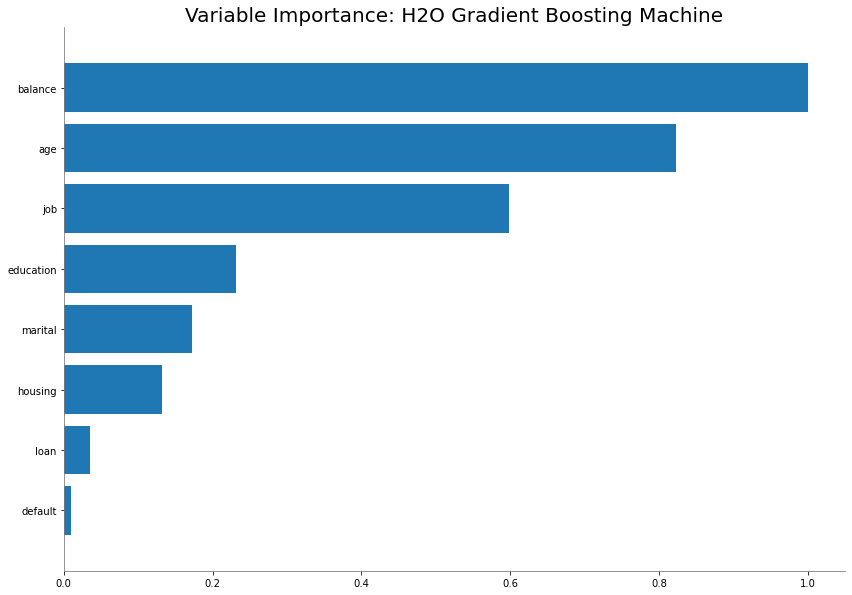

In [24]:
model.varimp_plot()